In [1]:
using OperatorApproximation, Plots

In [2]:
δ = .08
b = 1/(δ^(1)*sqrt(6))
c = b^3*δ^2
a = (6c)/b;
ss = 0.1
q0 = x -> 1/a*cos((x)*pi/b-0.1*pi)
L = 2*b

10.206207261596576

To get sheet

In [3]:
function get_cs(q,L,λ)
    gd = ChebyshevMappedInterval(0.0,L)
    sp = Ultraspherical(0.0,gd);
    D = Derivative()
    gv = GridValues(gd)
    E = Conversion(gv)
    M = Multiplication(x -> q0(x) + λ)
    Op = -E*D^2 - M*E
    bdryE = Conversion(FixedGridValues([0],gd))
    lbdry1 = bdryE;
    lbdry2 = bdryE*D
    L1 = (lbdry1 ⊘ lbdry2 ⊘ Op)*sp;
    c = (L1 \ [[1];[0]; x -> 0])[1]
    s = (L1 \ [[0];[1]; x -> 0])[1]
    c, s
end

function T(q,L,λ)
    D = Derivative()
    c, s = get_cs(q0,L,λ);
    dc = D*c; ds = D*s;
    [c(L) s(L); dc(L) ds(L)]
end

sqz = z -> sqrt(z-1 |> complex)*sqrt(1+z |> complex)
function find_sheet(q,L,λ)
    TT = T(q,L,λ)
    dd = (TT[1,1] + TT[2,2])/2
    sqdd = sqz(dd)
    s1 = sqdd + 1/2*(TT[2,2]-TT[1,1]) |> abs
    s2 = -sqdd + 1/2*(TT[2,2]-TT[1,1]) |> abs
    #println((s1,s2))
    if s1 > s2 # pole on sheet 1
        σ = 1.0
    else
        σ = -1.0 # pole on sheet 2
    end
    return σ
end

find_sheet (generic function with 1 method)

## Sparse ultraspherical

In [4]:
gd = ChebyshevMappedInterval(0.0,L)
sp = Ultraspherical(0.0,gd);
sp2 = Ultraspherical(2.0,gd);
D = Derivative()
C = Conversion(sp2)
M = Multiplication(q0)
Op = -D^2 - C*M
lbdry = FixedGridValues([0],gd) |> Conversion;
rbdry = FixedGridValues([L],gd) |> Conversion;
L2 = ((0*lbdry) ⊘ (0*rbdry) ⊘ C)*sp
L1 = (lbdry ⊘ rbdry ⊘ Op)*sp;
E = eigen(L1,L2,400);
(E.values |> real |> sort)[1:10]

10-element Vector{Float64}:
 -0.06362207764739117
  0.4323997569320811
  1.0388504765965814
  1.612500963427311
  2.424064506438312
  3.4490254818894686
  4.670261318616832
  6.0848765684448365
  7.691119567505878
  9.488158884056189

## Collocation

In [5]:
gd = ChebyshevMappedInterval(0.0,L)
sp = Ultraspherical(0.0,gd);
sp2 = Ultraspherical(2.0,gd);
D = Derivative()
gv = GridValues(gd)
E = Conversion(gv)
M = Multiplication(q0)
Op = -E*D^2 - M*E
lbdry = FixedGridValues([0],gd) |> Conversion;
rbdry = FixedGridValues([L],gd) |> Conversion;
L2 = ((0*lbdry) ⊘ (0*rbdry) ⊘ E)*sp
L1 = (lbdry ⊘ rbdry ⊘ Op)*sp;
E = eigen(L1,L2,400)
(E.values |> real |> sort)[1:10]

10-element Vector{Float64}:
 -0.06362207762131226
  0.4323997569417209
  1.0388504765566104
  1.612500963439636
  2.42406450665014
  3.44902548190008
  4.670261318545289
  6.084876568468324
  7.691119567768198
  9.488158884077857

In [6]:
dir_evals = (E.values |> real |> sort)[1:10]

10-element Vector{Float64}:
 -0.06362207762131226
  0.4323997569417209
  1.0388504765566104
  1.612500963439636
  2.42406450665014
  3.44902548190008
  4.670261318545289
  6.084876568468324
  7.691119567768198
  9.488158884077857

In [7]:
sheet = map(x -> find_sheet(q0,L,x),dir_evals)

10-element Vector{Float64}:
 -1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
 -1.0

In [8]:
gd = PeriodicMappedInterval(0.0,2L)
sp = Fourier(gd);
D = Derivative()
M = Multiplication(q0)
Op = -D^2 - M
L1 = Op*sp;
E = eigen(L1,300);
evals = E.values |> real |> sort;

In [9]:
α1 = evals[1] |> real

-0.5903366434877295

In [10]:
gaps = hcat(evals[2:2:20] |> real,evals[3:2:21] |> real)

10×2 Matrix{Float64}:
 -0.589564  0.160649
  0.180168  0.718802
  0.873261  1.11822
  1.58261   1.63404
  2.4224    2.42721
  3.44882   3.44908
  4.67026   4.67027
  6.08488   6.08488
  7.69112   7.69112
  9.48816   9.48816

In [11]:
zs = hcat(dir_evals,sheet)

10×2 Matrix{Float64}:
 -0.0636221  -1.0
  0.4324      1.0
  1.03885    -1.0
  1.6125      1.0
  2.42406    -1.0
  3.44903     1.0
  4.67026    -1.0
  6.08488     1.0
  7.69112    -1.0
  9.48816    -1.0

### Should be one Dirichlet eigenvalue in each gap

In [12]:
hcat(gaps,dir_evals) 

10×3 Matrix{Float64}:
 -0.589564  0.160649  -0.0636221
  0.180168  0.718802   0.4324
  0.873261  1.11822    1.03885
  1.58261   1.63404    1.6125
  2.4224    2.42721    2.42406
  3.44882   3.44908    3.44903
  4.67026   4.67027    4.67026
  6.08488   6.08488    6.08488
  7.69112   7.69112    7.69112
  9.48816   9.48816    9.48816

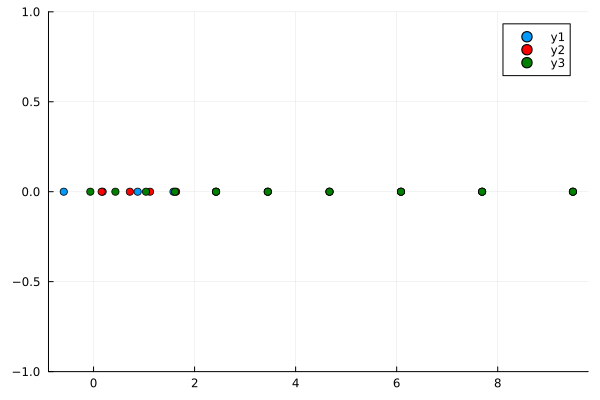

In [13]:
scatter(gaps[:,1],0*gaps[:,1], yaxis = [-1,1])
scatter!(gaps[:,2],0*gaps[:,1],markercolor = :red)
scatter!(dir_evals,0*dir_evals,markercolor = :green)